# OSS-DBS v2.0 Tutorial
At first import all needed modules. Besides OSS-DBS we  import the Draw function from Netgen/NGSolve webgui to visualze the results within the jupyter-notebook. The Taskmanager is used to paralize the computational expensive steps. If you want to use the default values for not-specified variables, you can use the `Settings` function from the `ossdbs.utils` module. 

In [3]:
from ngsolve.webgui import Draw as DrawNG
from ngsolve import TaskManager
from netgen.webgui import Draw
import logging
import ossdbs
from ossdbs.stimulation_signals import RectangleSignal
from ossdbs.utils.settings import Settings
ossdbs.set_logger(logging.INFO)


import matplotlib.pyplot as plt
import numpy as np

from ossdbs.stimulation_signals import RectangleSignal, TrapezoidSignal, TriangleSignal
from ossdbs.stimulation_signals.utilities import adjust_cutoff_frequency


--No graphics will be displayed.


## Input Settings
Define settings in dictionary format. Also an JSON file can be loaded.

In [5]:
settings = {
    "BrainRegion": {
        "Center": {"x[mm]": 17.0, "y[mm]": 8.0, "z[mm]": 6.0 },
        "Dimension": {"x[mm]": 280.0, "y[mm]": 200.0, "z[mm]": 200.0 },
        "Shape": "Ellipsoid"
    },
    

    "Electrodes":
    [
        {
        "Name": "Neuronexus",
        "CustomParameters": {
            "tip_length": 1.3,
            "contact_length": 1.5,
            "contact_spacing": 0.5,
            "lead_diameter": 1.3,
            "total_length": 100.0
      },
      "Rotation[Degrees]": 0.0,
      "Direction": { "x[mm]": 0.0, "y[mm]": 0.0, "z[mm]": 1.0 },
      "TipPosition": { "x[mm]": 17.0, "y[mm]": 8.0, "z[mm]": 6.0 },

      "Contacts": [
        {
          "Contact_ID": 1,
          "Active": True,
          "Current[A]": 0.0,
          "Voltage[V]": 1.0,
          "Floating": False,
          "SurfaceImpedance[Ohmm]": { "real": 0.0, "imag": 0.0 },
          "MaxMeshSizeEdge": 0.01
        },
        {
          "Contact_ID": 2,
          "Active": True,
          "Current[A]": 0.0,
          "Voltage[V]": 0.0,
          "Floating": False,
          "SurfaceImpedance[Ohmm]": { "real": 0.0, "imag": 0.0 },
          "MaxMeshSizeEdge": 0.01
        }
      ],
    "EncapsulationLayer": 
     {
        "Thickness[mm]": 0.0,
        "Material": "Blood",
        "DielectricModel": "ColeCole4",
        "MaxMeshSize": 0.5
     }
    }
  ],
  "MaterialDistribution": {
    "MRIPath": "../input_files/Butenko_segmask.nii.gz",
    "MRIMapping": {
      "Unknown": 0,
      "CSF": 1,
      "White matter": 2,
      "Gray matter": 3,
      "Blood": 4      
    },
    "DiffusionTensorActive": False,
    "DTIPath": ""
  },

  "DielectricModel": {
    "Type": "ColeCole4",
    "CustomParameters": None
  },

  "Mesh": {
    "LoadMesh": False,
    "MeshElementOrder": 2,
    "MeshingHypothesis": {
      "Type": "Default",
      "MaxMeshSize": 10.0
    },
    "MeshSize":{
      "Edges": {},
      "Faces":{"E1C1": 0.1},
      "Volumes":{"Brain": 0.5}
    },
    "SaveMesh": False
  },
    
  "FEMOrder": 2,
  "EQSMode": False, 

   "StimulationSignal": {
        "Type": "Rectangle",
        "Frequency[Hz]": 130.0,
        "PulseWidth[us]": 60e-6,
        "CounterPulseWidth[us]": 120e-6,
        "InterPulseWidth[us]": 120e-6,
        "CutoffFrequency": 1e5,
        "TopWidth[us]": 30e-6,
    },
    
    "Solver": 
    {
        "Type": "CG", 
        "Preconditioner": "bddc",
        "PreconditionerKwargs": {},
        "PrintRates": False,
        "MaximumSteps": 10000,
        "Precision": 1e-12
    },
    "PointModel": {
        "Pathway": {
            "Active": False, 
            "FileName": ""
        },
        "Lattice": {
            "Active": False,
            "Center": {"x[mm]": 22.95, "y[mm]": 11.47, "z[mm]": 8.1},
            "Shape": {"x": 10, "y": 10, "z": 10},
            "Direction": {"x[mm]": 0, "y[mm]": 0, "z[mm]": 1},
            "PointDistance[mm]": 0.1,
        },
        "VoxelLattice": {
            "Active": False,
            "Shape": {"x": 10, "y": 10, "z": 10},
            },
    },



    "OutputPath": "Results/",
    "ComputeImpedance": True,
    "TemplateSpace": False,
    "ActivationThresholdVTA": 0.2,
    "ExportVTK": True,
    "ExportElectrode": True,
    "OutOfCore": False,
    "PathwayFile": None,
    "AdaptiveMeshRefinement": False,


}

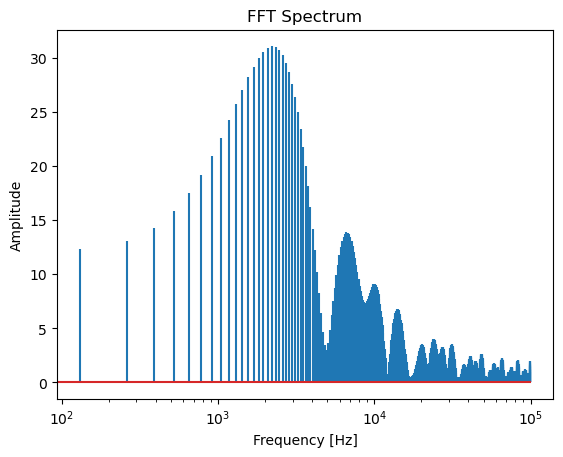

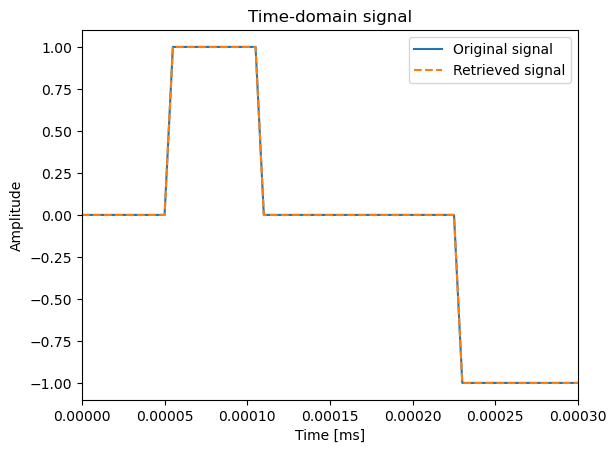

In [6]:
signal_type = settings["StimulationSignal"]["Type"]
frequency = settings["StimulationSignal"]["Frequency[Hz]"]
pulse_width = settings["StimulationSignal"]["PulseWidth[us]"]
counter_pulse_width = settings["StimulationSignal"]["CounterPulseWidth[us]"]
inter_pulse_width = settings["StimulationSignal"]["InterPulseWidth[us]"]
cutoff_frequency = settings["StimulationSignal"]["CutoffFrequency"]
top_width = settings["StimulationSignal"]["TopWidth[us]"]

adj_cutoff_frequency = adjust_cutoff_frequency(2.0 * cutoff_frequency, frequency)
dt = 1.0 / adj_cutoff_frequency
timesteps = int(adj_cutoff_frequency / frequency)

if signal_type == "Rectangle":
    signal = RectangleSignal(
        frequency, pulse_width, inter_pulse_width, counter_pulse_width
    )
elif signal_type == "Triangle":
    signal = TriangleSignal(
        frequency, pulse_width, inter_pulse_width, counter_pulse_width
    )
elif signal_type == "Trapezoid":
    signal = TrapezoidSignal(
        frequency, pulse_width, inter_pulse_width, top_width, counter_pulse_width
    )

time_domain_signal = signal.get_time_domain_signal(dt, timesteps)
fft_frequencies, fft_signal = signal.get_fft_spectrum(cutoff_frequency)

# Select only the positive frequencies
positive_indices = fft_frequencies >= 0
positive_frequencies = fft_frequencies[positive_indices]
positive_fft_signal = np.abs(fft_signal[positive_indices])

# Plot frequency domain signals
plt.stem(positive_frequencies, positive_fft_signal, markerfmt=" ")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xscale("log")
plt.title("FFT Spectrum")
plt.savefig("spectrum.png")
plt.show()

# Plot time domain signals (original and retrieved ones)
timesteps_retrieved, retrieved_signal = signal.retrieve_time_domain_signal(
    fft_signal, cutoff_frequency
)
plt.plot(dt * np.arange(timesteps), time_domain_signal, label="Original signal")
plt.plot(timesteps_retrieved, retrieved_signal, "--", label="Retrieved signal")
plt.xlim(left=0, right=3.0 * pulse_width + counter_pulse_width)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Time-domain signal")
plt.savefig("time_domain_signal.png")
plt.show()

## Update Settings
The following command will update all variables, which haven't been specified by the user with the default values.

In [8]:
settings = Settings(settings).complete_settings()
settings["MaterialDistribution"]["MRIPath"] = "/Users/pareesharma/OSS-DBSv2/input_files/Butenko_segmask.nii.gz"

## Load MRI and DTI Data
MRI and DTI were load from the path given in the settings dictionary. You always need to provide a MRI image, but DTI is optional.

In [10]:
mri_image, dti_image = ossdbs.load_images(settings)

INFO:ossdbs.api:Load MRI image


## Create Stimulation Electrodes
The specified electrodes were create and drawed. Geometrical parameters of the electrode can be changed directly in the input settings by appending "Custom" to the end of the electrodes' name and providing a dictionary with custum parameters.

In [12]:
electrodes = ossdbs.generate_electrodes(settings)
Draw(electrodes[0].geometry)

INFO:ossdbs.api:Generate electrode geometries
INFO:ossdbs.electrodes.electrode_model_template:Export electrode as VTK file


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

## Construct Geometry of the Brain
Since the region of interesst is relativly small compared to the brain size, the shape can be approximated by a ellipsoide, sphere, or a box. Also providing a custom shape in `.brep` format is possible.

In [14]:
region_parameters = settings["BrainRegion"]
brain_region = ossdbs.create_bounding_box(settings["BrainRegion"])
shape = settings["BrainRegion"]["Shape"]

brain = ossdbs.BrainGeometry(shape, brain_region)
#brain.import_geometry(path_to_geo_file="/Users/pareesharma/Denman Lab Summer/mouse_brain_meshed.step")


In [15]:
geometry = ossdbs.ModelGeometry(brain, electrodes)
Draw(geometry.geometry.shape)

INFO:ossdbs.electrodes.electrode_model_template:Boundary names updated


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

## Prepare the Volume Conductor Model
Before running the simulation, the material properties and corresponding conductivity values are determined based on the given inputs. Also the settings for the solver can be updated.

In [17]:
ossdbs.set_contact_and_encapsulation_layer_properties(settings, geometry)

dielectric_model = ossdbs.prepare_dielectric_properties(settings)

materials = settings["MaterialDistribution"]["MRIMapping"]
conductivity = ossdbs.ConductivityCF(mri_image,
                                  brain_region,
                                  dielectric_model,
                                  materials,
                                  geometry.encapsulation_layers,
                                  complex_data=settings["EQSMode"]
                                  )

solver = ossdbs.prepare_solver(settings)

frequency_domain_signal = ossdbs.prepare_stimulation_signal(settings)


INFO:ossdbs.api:Set values on contacts and encapsulation layers
INFO:ossdbs.api:Prepare dielectric model
INFO:ossdbs.api:Preparing solver


## Run Volume Conductor Model
To run the Volume Conductor Model, the built-in TaskManager is use to parallize the computational heavy parts. During this step, the results will be stored in the specified folder.

In [ ]:
with TaskManager():
    volume_conductor = ossdbs.prepare_volume_conductor_model(settings, geometry, conductivity, solver)
    ossdbs.run_volume_conductor_model(settings, volume_conductor, frequency_domain_signal)

INFO:ossdbs.api:Generate volume conductor model
INFO:ossdbs.api:Run volume conductor model
INFO:ossdbs.api:Output path set to: Results/
INFO:ossdbs.api:Will compute impedance at each frequency
INFO:ossdbs.api:Will export solution to VTK
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Set export frequency to 50050.0
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Computing at frequency: 0.0
/Users/pareesharma/Downloads/OSS-DBSv2/ossdbs/fem/volume_conductor/volume_conductor_model.py:600: RuntimeWarning: divide by zero encountered in scalar divide
  return voltage * np.conj(voltage) / power
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Copy solution to point models
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Computing at frequency: 130.0
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Copy solution to point models
INFO:ossdbs.fem.volume_conductor.volume_conductor_model:Computing at frequency: 260.0
INFO:ossdbs.fem.volume_conductor.volume_condu

In [ ]:
DrawNG(volume_conductor.potential)